# Skill estimation and outcome prediction using graphical models

In this project we are going to use graphical models to do some skill estimation amongst the players and using this model try to predict the outcome of certain matches in the tournament. We will first import data from an actual chess tournament along with the wins and losses for every round (for each player at least out of a maximum 7). Using this data we wil train our model using the first few rounds and try to predict the outcome for the remaining.

In [1]:
import pyGMs as gm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline         

### Loading the data of games & outcomes

In [2]:
import pandas as pd
# Create a dataframe from csv
df = pd.read_csv('Chess_Player_Matches.csv', delimiter=',')
# Create a list of tuples for dataframe
games = [list(row) for row in df.values]


In [3]:
nplayers = max( [max(g[0],g[1]) for g in games] )

In [4]:
nplayers

64

In [90]:
performance_ratings = np.zeros(nplayers)

for item in games:
    performance_ratings[item[3]] = item[4]
    if item[2] == 'W':
        item[2] = 1
    elif item[2] == 'L':
        item[2] = -1
    elif item[2] == 'D':
        item[2] = 0
performance_ratings     

array([   0., 1794., 1553., 1384., 1716., 1655., 1686., 1649., 1641.,
       1411., 1365., 1712., 1663., 1666., 1610., 1220., 1604., 1629.,
       1600., 1564., 1595., 1563., 1555., 1363., 1229., 1745., 1579.,
       1552., 1507., 1602., 1522., 1494., 1441., 1449., 1399., 1438.,
       1355.,  980., 1423., 1436., 1348., 1403., 1332., 1283., 1199.,
       1242.,  377., 1362., 1382., 1291., 1056., 1011.,  935., 1393.,
       1270., 1186., 1153., 1092.,  917.,  853.,  967.,  955., 1530.,
       1175., 1163.])

In [6]:
games
#player_num	round	outcome	opponent_num	opponent_pre_rating


[[1, 1, 1, 39, 1436],
 [1, 2, 1, 21, 1563],
 [1, 3, 1, 18, 1600],
 [1, 4, 1, 14, 1610],
 [1, 5, 1, 7, 1649],
 [1, 6, 0, 12, 1663],
 [1, 7, 0, 4, 1716],
 [2, 1, 1, 63, 1175],
 [2, 2, 1, 58, 917],
 [2, 3, -1, 4, 1716],
 [2, 4, 1, 17, 1629],
 [2, 5, 1, 16, 1604],
 [2, 6, 1, 20, 1595],
 [2, 7, 1, 7, 1649],
 [3, 1, -1, 8, 1641],
 [3, 2, 1, 61, 955],
 [3, 3, 1, 25, 1745],
 [3, 4, 1, 21, 1563],
 [3, 5, 1, 11, 1712],
 [3, 6, 1, 13, 1666],
 [3, 7, 1, 12, 1663],
 [4, 1, 1, 23, 1363],
 [4, 2, 0, 28, 1507],
 [4, 3, 1, 2, 1553],
 [4, 4, 1, 26, 1579],
 [4, 5, 0, 5, 1655],
 [4, 6, 1, 19, 1564],
 [4, 7, 0, 1, 1794],
 [5, 1, 1, 45, 1242],
 [5, 2, 1, 37, 980],
 [5, 3, 0, 12, 1663],
 [5, 4, 0, 13, 1666],
 [5, 5, 0, 4, 1716],
 [5, 6, 1, 14, 1610],
 [5, 7, 1, 17, 1629],
 [6, 1, 1, 34, 1399],
 [6, 2, 0, 29, 1602],
 [6, 3, -1, 11, 1712],
 [6, 4, 1, 35, 1438],
 [6, 5, 0, 10, 1365],
 [6, 6, 1, 27, 1552],
 [6, 7, 1, 21, 1563],
 [7, 1, 1, 57, 1092],
 [7, 2, 1, 46, 377],
 [7, 3, 1, 13, 1666],
 [7, 4, 1, 11, 1712]

### Win probability and graphical model

In [91]:
#g[0]=player, g[3]=opponent
nplayers = max( [max(g[0],g[3]) for g in games] )+1 
nlevels = 10   # let's say 10 discrete skill levels
scale = .064 # this scales how skill difference translates to win probability
# Make variables for each player; value = skill level
X = [None]*nplayers
for i in range(nplayers):
    X[i] = gm.Var(i, nlevels) 


# Information from each game: what does Pi winning over Pj tell us?
#    Win probability  Pr[win | Xi-Xj]  depends on skill difference of players
Pwin = np.zeros( (nlevels,nlevels) )
for i in range(nlevels):
    for j in range(nlevels):
        diff = i-j                   # find the advantage of Pi over Pj, then 
        Pwin[i,j] = (1./(1+np.exp(-scale*diff)))  # Pwin = logistic of advantage

# before any games, uniform belief over skill levels for each player:
factors = [ gm.Factor([X[i]],1./nlevels) for i in range(nplayers) ]

# Now add the information from each game:
for g in games:
#     print(g[2])
    P1,P2,win = g[0],g[3],g[2]
    if P1>P2: P1,P2,win=P2,P1,-win  # (need to make player IDs sorted...)
    factors.append(gm.Factor([X[P1],X[P2]], Pwin if win>0 else 1-Pwin) )
    performance_ratings[g[0]] +=  400 * (g[2])

In [92]:
for i in range(nplayers):
    performance_ratings[i] += performance_ratings[i]/ 7


In [93]:
performance_ratings

array([   0.        , 4336.        , 4060.57142857, 3867.42857143,
       3789.71428571, 3720.        , 3298.28571429, 3256.        ,
       3246.85714286, 2984.        , 2931.42857143, 2870.85714286,
       2814.85714286, 2818.28571429, 2754.28571429, 2308.57142857,
       2747.42857143, 2318.85714286, 2285.71428571, 2244.57142857,
       2280.        , 2243.42857143, 2234.28571429, 2014.85714286,
       1861.71428571, 1994.28571429, 1804.57142857, 2230.85714286,
       1722.28571429, 2288.        , 1739.42857143, 1707.42857143,
       1646.85714286, 1656.        , 1598.85714286, 1643.42857143,
       1548.57142857,  662.85714286, 1169.14285714, 1184.        ,
       1083.42857143, 1603.42857143, 1065.14285714, 1009.14285714,
        456.        ,  962.28571429,  -26.28571429,  642.28571429,
        665.14285714, 1018.28571429,  292.57142857,  241.14285714,
        154.28571429, 1134.85714286, -377.14285714, -473.14285714,
        -53.71428571, -580.57142857, -780.57142857, -853.71428

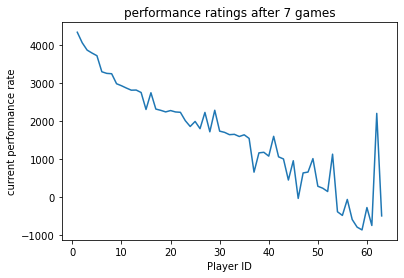

In [96]:
plt.plot(X[1:64],performance_ratings[1:64])
plt.title('performance ratings after 7 games')
plt.xlabel('Player ID')
plt.ylabel('current performance rate')
plt.show()

In [8]:
Pwin

array([[0.5       , 0.48400546, 0.46804362, 0.45214691, 0.43634725,
        0.42067575, 0.40516251, 0.38983639, 0.3747248 , 0.35985351],
       [0.51599454, 0.5       , 0.48400546, 0.46804362, 0.45214691,
        0.43634725, 0.42067575, 0.40516251, 0.38983639, 0.3747248 ],
       [0.53195638, 0.51599454, 0.5       , 0.48400546, 0.46804362,
        0.45214691, 0.43634725, 0.42067575, 0.40516251, 0.38983639],
       [0.54785309, 0.53195638, 0.51599454, 0.5       , 0.48400546,
        0.46804362, 0.45214691, 0.43634725, 0.42067575, 0.40516251],
       [0.56365275, 0.54785309, 0.53195638, 0.51599454, 0.5       ,
        0.48400546, 0.46804362, 0.45214691, 0.43634725, 0.42067575],
       [0.57932425, 0.56365275, 0.54785309, 0.53195638, 0.51599454,
        0.5       , 0.48400546, 0.46804362, 0.45214691, 0.43634725],
       [0.59483749, 0.57932425, 0.56365275, 0.54785309, 0.53195638,
        0.51599454, 0.5       , 0.48400546, 0.46804362, 0.45214691],
       [0.61016361, 0.59483749, 0.5793242

In [10]:
model = gm.GraphModel(factors)
model.makeMinimal()  # merge any duplicate factors (e.g., repeated games)

In [11]:
if model.nvar < 0:       # for very small models, we can do brute force inference:
    jt = model.joint()
    jt /= jt.sum()       # normalize the distribution and marginalize the table
    bel = [jt.marginal([i]) for i in range(nplayers)] 
else:                    # otherwise we need to use some approximate inference:
    from pyGMs.messagepass import LBP, NMF
    lnZ,bel = LBP(model, maxIter=10, verbose=True)   # loopy BP
    #lnZ,bel = NMF(model, maxIter=10, verbose=True)  # Mean field

Iter 1: -253.74523760175262
Iter 2: -278.64628549038645
Iter 3: -280.5017713968641
Iter 4: -280.5508363628494
Iter 5: -280.55156983784144
Iter 6: -280.55157225972766
Iter 7: -280.5515722866719
Iter 8: -280.55157234368477
Iter 9: -280.5515723500323
Iter 10: -280.5515723505875


The normalization constant, $\log(Z)$, represents the (log) probability of evidence for our model, namely the probability of the observed game outcomes given our parameters, etc.  We could experiment with changing the win probability function or its scaling parameter to try to make our model better fit the data using this value.


###  Ranking players by predicted skill

Mean skill estimates: 
player 1: 0.45
player 2: 0.6014
player 3: 0.6719
player 4: 0.6737
player 5: 0.6019
player 6: 0.5987
player 7: 0.507
player 8: 0.5998
player 9: 0.5993
player 10: 0.595
player 11: 0.5949
player 12: 0.5046999999999999
player 13: 0.6388
player 14: 0.603
player 15: 0.5032
player 16: 0.4989
player 17: 0.6013
player 18: 0.5035999999999999
player 19: 0.5065999999999999
player 20: 0.5104
player 21: 0.5042
player 22: 0.5021
player 23: 0.45010000000000006
player 24: 0.4988
player 25: 0.49400000000000005
player 26: 0.4064
player 27: 0.40380000000000005
player 28: 0.5506
player 29: 0.5088
player 30: 0.5477000000000001
player 31: 0.3927
player 32: 0.3937
player 33: 0.5002
player 34: 0.4043
player 35: 0.5018
player 36: 0.3934
player 37: 0.5501
player 38: 0.4025
player 39: 0.4563
player 40: 0.40069999999999995
player 41: 0.3948
player 42: 0.4457
player 43: 0.29860000000000003
player 44: 0.39449999999999996
player 45: 0.3489
player 46: 0.2994
player 47: 0.3989
player 48: 0.3075
p

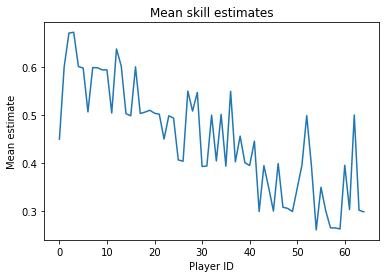

In [60]:
print("Mean skill estimates: ")
scores = np.zeros(nplayers)
for i in range(nplayers):
    scores[i] = round(bel[i].table.dot(np.arange(nlevels)),3)/10
    print("player " + str(i+1) + ": "+str(round(bel[i].table.dot(np.arange(nlevels)),3)/10))
accuracies_mean = np.array([np.mean(v) for v in bel])
print(scores)
plt.plot(X, scores)
plt.title('Mean skill estimates')
plt.xlabel('Player ID')
plt.ylabel('Mean estimate')
plt.show()

### Estimating Skill Level

In [33]:
scores1 = np.zeros(nplayers)
scores2 = np.zeros(nplayers)

for i in range(1,64):
    for j in range(1,64):
        if (i!=j):
            print("Estimated probability P{} beats P{} next time:".format(i,j))
            # Expected value (over skill of P0, P1) of Pr[win | P0-P1]
            if i<j:
                scores1[i] = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum()
                print( (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum() )
            elif i>j:
                scores2[i] = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum()
                print( (bel[i]*bel[j]*gm.Factor([X[i],X[j]],1-Pwin)).table.sum() )

# Notes: we should probably use the joint belief over Xi and Xj, but for simplicity
#  with approximate inference we'll just use the estimated singleton marginals

Estimated probability P1 beats P2 next time:
0.4888487969788061
Estimated probability P1 beats P3 next time:
0.48855292400942146
Estimated probability P1 beats P4 next time:
0.4999145875781899
Estimated probability P1 beats P5 next time:
0.5004232737180352
Estimated probability P1 beats P6 next time:
0.5149029470322134
Estimated probability P1 beats P7 next time:
0.5002388198849486
Estimated probability P1 beats P8 next time:
0.5003250535835265
Estimated probability P1 beats P9 next time:
0.5009987926424638
Estimated probability P1 beats P10 next time:
0.5010162471261492
Estimated probability P1 beats P11 next time:
0.5152782328176868
Estimated probability P1 beats P12 next time:
0.4940730803819574
Estimated probability P1 beats P13 next time:
0.49973855586811644
Estimated probability P1 beats P14 next time:
0.5155006285956824
Estimated probability P1 beats P15 next time:
0.5161872860109007
Estimated probability P1 beats P16 next time:
0.5000032610773867
Estimated probability P1 beats 

0.5325215536121655
Estimated probability P5 beats P31 next time:
0.532372967022513
Estimated probability P5 beats P32 next time:
0.5155543167577893
Estimated probability P5 beats P33 next time:
0.5306941098425401
Estimated probability P5 beats P34 next time:
0.5152999694692856
Estimated probability P5 beats P35 next time:
0.5324175778025235
Estimated probability P5 beats P36 next time:
0.5076731736925263
Estimated probability P5 beats P37 next time:
0.5309795433659545
Estimated probability P5 beats P38 next time:
0.5224930809402768
Estimated probability P5 beats P39 next time:
0.5312550641331797
Estimated probability P5 beats P40 next time:
0.5321906017868214
Estimated probability P5 beats P41 next time:
0.5241643517583271
Estimated probability P5 beats P42 next time:
0.5473479425912829
Estimated probability P5 beats P43 next time:
0.5322323595727013
Estimated probability P5 beats P44 next time:
0.5394335018552312
Estimated probability P5 beats P45 next time:
0.5472252980590958
Estimat

0.5151714979820987
Estimated probability P10 beats P16 next time:
0.4989871022154007
Estimated probability P10 beats P17 next time:
0.514432279099307
Estimated probability P10 beats P18 next time:
0.513959258496962
Estimated probability P10 beats P19 next time:
0.5133596240285317
Estimated probability P10 beats P20 next time:
0.5143343279011845
Estimated probability P10 beats P21 next time:
0.5146646244535951
Estimated probability P10 beats P22 next time:
0.5228817519034754
Estimated probability P10 beats P23 next time:
0.5151847480998376
Estimated probability P10 beats P24 next time:
0.5159480728699812
Estimated probability P10 beats P25 next time:
0.529776217714832
Estimated probability P10 beats P26 next time:
0.5301767275744523
Estimated probability P10 beats P27 next time:
0.507004167323262
Estimated probability P10 beats P28 next time:
0.5136048759197741
Estimated probability P10 beats P29 next time:
0.5074604769922257
Estimated probability P10 beats P30 next time:
0.531929666750

0.5161906267150628
Estimated probability P14 beats P40 next time:
0.5171273271582577
Estimated probability P14 beats P41 next time:
0.5090948884797738
Estimated probability P14 beats P42 next time:
0.5323100223638755
Estimated probability P14 beats P43 next time:
0.5171691372555592
Estimated probability P14 beats P44 next time:
0.5243814904292932
Estimated probability P14 beats P45 next time:
0.5321871221432776
Estimated probability P14 beats P46 next time:
0.5164878095776886
Estimated probability P14 beats P47 next time:
0.5309056663926064
Estimated probability P14 beats P48 next time:
0.531309551632782
Estimated probability P14 beats P49 next time:
0.5323271544581898
Estimated probability P14 beats P50 next time:
0.5246571639793458
Estimated probability P14 beats P51 next time:
0.5169959974630945
Estimated probability P14 beats P52 next time:
0.5006227203564496
Estimated probability P14 beats P53 next time:
0.5173668950221559
Estimated probability P14 beats P54 next time:
0.538409887

0.5175800284817584
Estimated probability P18 beats P61 next time:
0.5322244929445252
Estimated probability P18 beats P62 next time:
0.5009652114312538
Estimated probability P18 beats P63 next time:
0.5324301148692914
Estimated probability P19 beats P1 next time:
0.4856244895043571
Estimated probability P19 beats P2 next time:
0.4744814758641375
Estimated probability P19 beats P3 next time:
0.474185933645974
Estimated probability P19 beats P4 next time:
0.48553910967315334
Estimated probability P19 beats P5 next time:
0.4860476041785743
Estimated probability P19 beats P6 next time:
0.5005276394784929
Estimated probability P19 beats P7 next time:
0.485863215983349
Estimated probability P19 beats P8 next time:
0.48594942010908404
Estimated probability P19 beats P9 next time:
0.48662292513908645
Estimated probability P19 beats P10 next time:
0.4866403759714684
Estimated probability P19 beats P11 next time:
0.5009030744062088
Estimated probability P19 beats P12 next time:
0.4797014792427562

0.5377114256718071
Estimated probability P23 beats P55 next time:
0.5236301464866338
Estimated probability P23 beats P56 next time:
0.5313723595035423
Estimated probability P23 beats P57 next time:
0.5370187680075346
Estimated probability P23 beats P58 next time:
0.5370636248459011
Estimated probability P23 beats P59 next time:
0.5373838049073577
Estimated probability P23 beats P60 next time:
0.5163547881515086
Estimated probability P23 beats P61 next time:
0.5310006095755124
Estimated probability P23 beats P62 next time:
0.49973963666775384
Estimated probability P23 beats P63 next time:
0.5312063664855279
Estimated probability P24 beats P1 next time:
0.48303618477648375
Estimated probability P24 beats P2 next time:
0.47189551415789965
Estimated probability P24 beats P3 next time:
0.4716000545264575
Estimated probability P24 beats P4 next time:
0.48295081746769564
Estimated probability P24 beats P5 next time:
0.48345923783751965
Estimated probability P24 beats P6 next time:
0.497938210

0.49143804863243346
Estimated probability P29 beats P5 next time:
0.4919466433416092
Estimated probability P29 beats P6 next time:
0.50642714402437
Estimated probability P29 beats P7 next time:
0.4917622203915959
Estimated probability P29 beats P8 next time:
0.4918484403086196
Estimated probability P29 beats P9 next time:
0.4925220699370178
Estimated probability P29 beats P10 next time:
0.49253952300777437
Estimated probability P29 beats P11 next time:
0.5068025336628357
Estimated probability P29 beats P12 next time:
0.48559857976287724
Estimated probability P29 beats P13 next time:
0.49126205030845604
Estimated probability P29 beats P14 next time:
0.5070249928775384
Estimated probability P29 beats P15 next time:
0.5077118597619675
Estimated probability P29 beats P16 next time:
0.4915274421411119
Estimated probability P29 beats P17 next time:
0.5069724589366228
Estimated probability P29 beats P18 next time:
0.5064993293435801
Estimated probability P29 beats P19 next time:
0.50589956546

0.48384549498927026
Estimated probability P33 beats P19 next time:
0.48324593413564776
Estimated probability P33 beats P20 next time:
0.48422053789914266
Estimated probability P33 beats P21 next time:
0.48455082146351747
Estimated probability P33 beats P22 next time:
0.4927727516746711
Estimated probability P33 beats P23 next time:
0.48507095363106867
Estimated probability P33 beats P24 next time:
0.4858343373628182
Estimated probability P33 beats P25 next time:
0.49967361446479597
Estimated probability P33 beats P26 next time:
0.5000747369608497
Estimated probability P33 beats P27 next time:
0.47689500660388623
Estimated probability P33 beats P28 next time:
0.4834911540270548
Estimated probability P33 beats P29 next time:
0.47735095969865166
Estimated probability P33 beats P30 next time:
0.501830533550163
Estimated probability P33 beats P31 next time:
0.5016816794395721
Estimated probability P33 beats P32 next time:
0.48484779245030146
Estimated probability P33 beats P34 next time:
0.

0.5002727964524707
Estimated probability P37 beats P40 next time:
0.5012098360735804
Estimated probability P37 beats P41 next time:
0.49317848343291565
Estimated probability P37 beats P42 next time:
0.5164049045629662
Estimated probability P37 beats P43 next time:
0.5012516617430651
Estimated probability P37 beats P44 next time:
0.5084690119846206
Estimated probability P37 beats P45 next time:
0.5162818508649298
Estimated probability P37 beats P46 next time:
0.5005700824132503
Estimated probability P37 beats P47 next time:
0.5149988358902498
Estimated probability P37 beats P48 next time:
0.5154046077384488
Estimated probability P37 beats P49 next time:
0.5164234442555315
Estimated probability P37 beats P50 next time:
0.5087449027104414
Estimated probability P37 beats P51 next time:
0.5010784540586724
Estimated probability P37 beats P52 next time:
0.4847061054491538
Estimated probability P37 beats P53 next time:
0.5014527199098694
Estimated probability P37 beats P54 next time:
0.5225143

0.4408431442002171
Estimated probability P42 beats P4 next time:
0.4521454056257186
Estimated probability P42 beats P5 next time:
0.45265205740871695
Estimated probability P42 beats P6 next time:
0.467093139095967
Estimated probability P42 beats P7 next time:
0.4524683284676872
Estimated probability P42 beats P8 next time:
0.452554226969552
Estimated probability P42 beats P9 next time:
0.4532253372696
Estimated probability P42 beats P10 next time:
0.4532427316569701
Estimated probability P42 beats P11 next time:
0.46746788884775076
Estimated probability P42 beats P12 next time:
0.4463328232372789
Estimated probability P42 beats P13 next time:
0.45197008774026376
Estimated probability P42 beats P14 next time:
0.46768997763612447
Estimated probability P42 beats P15 next time:
0.46837576386567376
Estimated probability P42 beats P16 next time:
0.4522378678750394
Estimated probability P42 beats P17 next time:
0.4676375354524213
Estimated probability P42 beats P18 next time:
0.46716519521954

Estimated probability P46 beats P61 next time:
0.5152254987272978
Estimated probability P46 beats P62 next time:
0.4839566947033912
Estimated probability P46 beats P63 next time:
0.5154329030168191
Estimated probability P47 beats P1 next time:
0.4536318501516495
Estimated probability P47 beats P2 next time:
0.4425355096966461
Estimated probability P47 beats P3 next time:
0.44224145789527475
Estimated probability P47 beats P4 next time:
0.45354676085476625
Estimated probability P47 beats P5 next time:
0.4540535305165065
Estimated probability P47 beats P6 next time:
0.46849740188622135
Estimated probability P47 beats P7 next time:
0.45386975920589734
Estimated probability P47 beats P8 next time:
0.4539556774076753
Estimated probability P47 beats P9 next time:
0.45462694191143505
Estimated probability P47 beats P10 next time:
0.45464434005932314
Estimated probability P47 beats P11 next time:
0.4688722103428713
Estimated probability P47 beats P12 next time:
0.4477326619834291
Estimated pro

0.4837915597582364
Estimated probability P52 beats P5 next time:
0.4843000054412428
Estimated probability P52 beats P6 next time:
0.4987793580751342
Estimated probability P52 beats P7 next time:
0.4841156344814652
Estimated probability P52 beats P8 next time:
0.48420183068480604
Estimated probability P52 beats P9 next time:
0.48487527345566267
Estimated probability P52 beats P10 next time:
0.48489272296821706
Estimated probability P52 beats P11 next time:
0.49915479229933973
Estimated probability P52 beats P12 next time:
0.47795469367083804
Estimated probability P52 beats P13 next time:
0.4836156145801914
Estimated probability P52 beats P14 next time:
0.4993772796435503
Estimated probability P52 beats P15 next time:
0.5000642456535725
Estimated probability P52 beats P16 next time:
0.4838815910960972
Estimated probability P52 beats P17 next time:
0.4993247398927287
Estimated probability P52 beats P18 next time:
0.4988515507714907
Estimated probability P52 beats P19 next time:
0.49825172

0.5060223854664708
Estimated probability P56 beats P60 next time:
0.48497091406504944
Estimated probability P56 beats P61 next time:
0.4996248918046905
Estimated probability P56 beats P62 next time:
0.4683773445595073
Estimated probability P56 beats P63 next time:
0.4998337323669438
Estimated probability P57 beats P1 next time:
0.4468365005173299
Estimated probability P57 beats P2 next time:
0.43575587845702546
Estimated probability P57 beats P3 next time:
0.4354622970856064
Estimated probability P57 beats P4 next time:
0.44675151743213304
Estimated probability P57 beats P5 next time:
0.44725765569495185
Estimated probability P57 beats P6 next time:
0.46168629584295146
Estimated probability P57 beats P7 next time:
0.4470741115214656
Estimated probability P57 beats P8 next time:
0.4471599240591284
Estimated probability P57 beats P9 next time:
0.447830361612822
Estimated probability P57 beats P10 next time:
0.4478477394729251
Estimated probability P57 beats P11 next time:
0.4620607754363

0.4984351414088524
Estimated probability P62 beats P20 next time:
0.4994098756019303
Estimated probability P62 beats P21 next time:
0.4997401928055999
Estimated probability P62 beats P22 next time:
0.5079603745456941
Estimated probability P62 beats P23 next time:
0.5002603633322462
Estimated probability P62 beats P24 next time:
0.5010237799285323
Estimated probability P62 beats P25 next time:
0.514858576298998
Estimated probability P62 beats P26 next time:
0.5152594226418977
Estimated probability P62 beats P27 next time:
0.49208140835339703
Estimated probability P62 beats P28 next time:
0.4986803975535734
Estimated probability P62 beats P29 next time:
0.49253757870970505
Estimated probability P62 beats P30 next time:
0.5170139217763758
Estimated probability P62 beats P31 next time:
0.5168651854377181
Estimated probability P62 beats P32 next time:
0.5000371876096158
Estimated probability P62 beats P33 next time:
0.5151847375463955
Estimated probability P62 beats P34 next time:
0.4997828

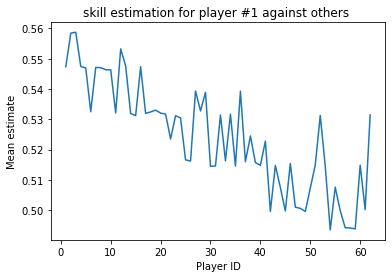

In [43]:
plt.plot(X[1:63],scores1[1:63])
plt.title('skill estimation for player #1 against others ')
plt.xlabel('Player ID')
plt.ylabel('Mean estimate')
plt.show()

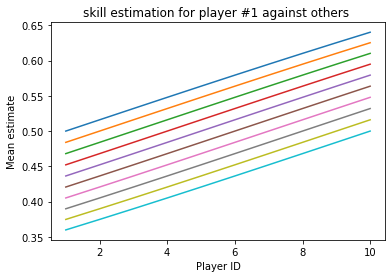

In [50]:
plt.plot([1,2,3,4,5,6,7,8,9,10],Pwin)
plt.title('skill estimation for player #1 against others ')
plt.xlabel('Player ID')
plt.ylabel('Mean estimate')
plt.show()